## Making diagnostic plots

For comparison of power spectra after changing flag broadcasting.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import copy
import hera_pspec as hp
from pyuvdata import UVData
from hera_qm.metrics_io import process_ex_ants
import utils

In [2]:
# Paths
JD_dec = '49088'
time_thresh_str = '0.1' # For flag broadcasting
base_name = 'zen.2458106.' + JD_dec + '.xx.HH'
beam_file = '/home/lwhitler/data/dfiles/HERA_NF_dipole_power.beamfits'
data_file = '/data6/HERA/data/IDR2.1/2458106/' + base_name + '.uvOCRS'
ant_metrics = '/data6/HERA/data/IDR2.1/2458106/' + base_name.replace('.xx','') + '.uv.ant_metrics.json'
uvp_prefix = '/home/lwhitler/data/dfiles/pspecs/broadcasting/tt' + time_thresh_str + '/' + base_name + ''
im_prefix = 'plots/' + base_name

In [3]:
# Models and data
cosmo = hp.conversions.Cosmo_Conversions()
beam = hp.pspecbeam.PSpecBeamUV(beam_file, cosmo=cosmo)
uvd_load = UVData()
uvd_load.read(data_file, file_type='miriad')

In [4]:
# Convert from Jy to mK
uvd_orig, uvd = copy.deepcopy(uvd_load), copy.deepcopy(uvd_load)
utils.aux.convert_Jy_to_mK(uvd_orig, beam)
utils.aux.convert_Jy_to_mK(uvd, beam)

#### Choose data to make the power spectra

In [5]:
# Select the baseline pairs without bad antennas
reds = hp.utils.get_reds(uvd)[0]
bls = reds[2]  # 14-m EW baselines
bl_str = 'EW_14m'  # For saving files

xants = process_ex_ants(metrics_file=ant_metrics)  # Bad antennas
good_bls = utils.aux.find_good_bls(bls, xants)
blps = hp.utils.construct_blpairs(good_bls, exclude_auto_bls=True, exclude_permutations=True)
bls1, bls2 = blps[0], blps[1]

# Select the spectral window
spw = [(512, 640)]
spw_str = str(spw[0][0]) + '-' + str(spw[0][1])  # For saving files

# Time threshold for broadcasting flags
time_thresh = float(time_thresh_str)

#### Make/load the power spectra

Default flag broadcasting has a time threshold of 0.2.

In [6]:
uvp_orig_file = uvp_prefix.replace(time_thresh_str, '0.2') + '.ps.' + spw_str + '.' + bl_str + '.' + uvd_orig.vis_units + '.h5'
uvp_file = uvp_prefix + '.ps.' + spw_str + '.' + bl_str + '.' + uvd.vis_units + '.h5'
ds_orig, uvp_orig = utils.aux.get_uvpspec(uvd_orig, beam, bls1, bls2, spw, uvp_orig_file, time_thresh=0.2)
ds, uvp = utils.aux.get_uvpspec(uvd, beam, bls1, bls2, spw, uvp_file, time_thresh=time_thresh)

invalid value encountered in divide
invalid value encountered in greater


/home/lwhitler/data/dfiles/pspecs/broadcasting/tt0.2/zen.2458106.49088.xx.HH.ps.512-640.EW_14m.mK.h5 exists, loading UVPSpec...
/home/lwhitler/data/dfiles/pspecs/broadcasting/tt0.1/zen.2458106.49088.xx.HH.ps.512-640.EW_14m.mK.h5 exists, loading UVPSpec...


In [7]:
# Take the time average of the spectra
uvp_avg_orig = uvp_orig.average_spectra(time_avg=True, inplace=False)
uvp_avg = uvp.average_spectra(time_avg=True, inplace=False)
# Save the baseline pairs
blpairs = list(np.unique(uvp_avg.blpair_array))
kparas = uvp_avg.get_kparas(0)

In [8]:
# Remove zero data and corresponding baselines
zero_wgt = np.all(uvp_avg.wgt_array[0][:, :, 0] == 0, axis=1)
zero_wgt_mask = np.broadcast_to(zero_wgt, uvp_avg.data_array[0][:, :, 0].shape)
zero_wgt_mask = zero_wgt_mask[:, :, np.newaxis]
nonzero_blpairs = uvp_avg.blpair_array[~zero_wgt[:, 0]]
uvp_avg_orig.data_array[0] = np.ma.masked_array(uvp_avg_orig.data_array[0], zero_wgt_mask)
uvp_avg.data_array[0] = np.ma.masked_array(uvp_avg.data_array[0], zero_wgt_mask)

In [9]:
# Calculate the median, bootstrapped errors, and the difference
niters = 1000
med_orig = utils.aux.calc_median(uvp_avg_orig, blpairs=nonzero_blpairs)
med = utils.aux.calc_median(uvp_avg, blpairs=nonzero_blpairs)
med_err_orig = utils.aux.bootstrap_median(uvp_avg_orig, blpairs=nonzero_blpairs, niters=niters)
med_err = utils.aux.bootstrap_median(uvp_avg, blpairs=nonzero_blpairs, niters=niters)
med_diff, med_diff_err = utils.aux.subtract_medians(med_orig, med, med_err_orig, med_err)

#### Plot the flags and the power spectra

<IPython.core.display.Javascript object>


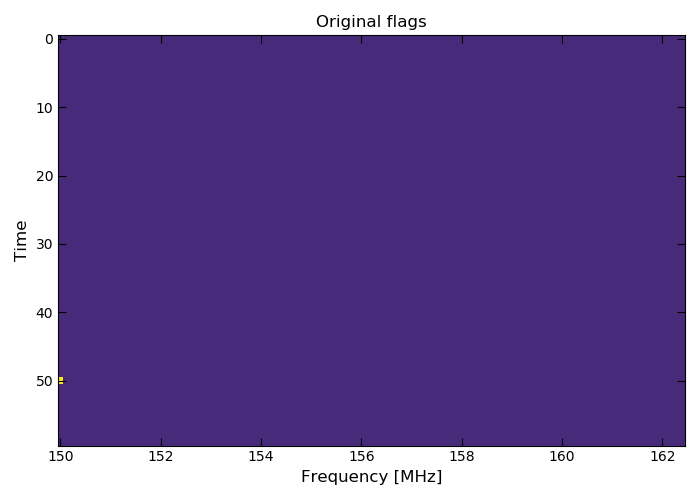

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 5))
utils.plot.plot_flag_frac(uvd_load, spw[0], good_bls, ax1, xtick_space=2, vmin=0, vmax=1)
ax1.set_title('Original flags')
plt.tight_layout()
plt.savefig(im_prefix + '.orig_flags.png', format='png')

<IPython.core.display.Javascript object>


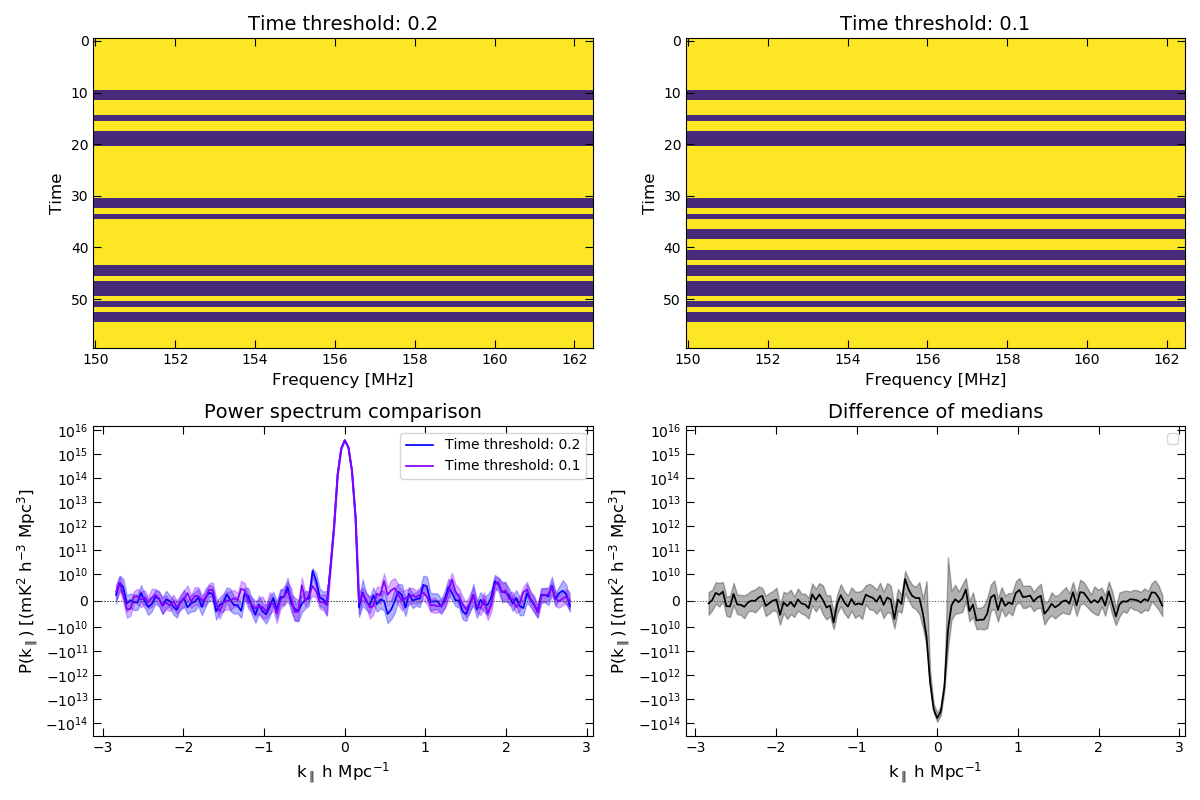

In [11]:
fig2, ax2 = plt.subplots(2, 2, sharey='row', figsize=(12, 8))
utils.plot.plot_flag_frac(ds_orig.dsets[0], spw[0], good_bls, ax2[0, 0], xtick_space=2, vmin=0, vmax=1)
utils.plot.plot_flag_frac(ds.dsets[0], spw[0], good_bls, ax2[0, 1], xtick_space=2, vmin=0, vmax=1)
utils.plot.plot_median_spectra(kparas, med_orig, med_err_orig, ax2[1, 0],
                               vis_units=uvd_orig.vis_units, color='#0700FF',
                               label='Time threshold: 0.2')
utils.plot.plot_median_spectra(kparas, med, med_err, ax2[1, 0], vis_units=uvd.vis_units,
                               color='#8600FF', label='Time threshold: {0}'.format(time_thresh_str))
utils.plot.plot_median_spectra(kparas, med_diff, med_diff_err, ax2[1, 1],
                               vis_units=uvd.vis_units, color='#000000')

ax2[0, 1].yaxis.set_tick_params(labelleft=True)
ax2[1, 1].yaxis.set_tick_params(labelleft=True)
ax2[0, 0].set_title('Time threshold: 0.2', fontsize=14)
ax2[0, 1].set_title('Time threshold: {0}'.format(time_thresh_str), fontsize=14)
linthreshy = np.max(med)*1e-5
linthreshy = 10**np.floor(np.log10(linthreshy))
ax2[1, 0].set_yscale('symlog', linthreshy=linthreshy)
ax2[1, 1].set_yscale('symlog', linthreshy=linthreshy)
ax2[1, 0].set_title('Power spectrum comparison', fontsize=14)
ax2[1, 1].set_title('Difference of medians', fontsize=14)
ax2[1, 0].legend(loc='best')
ax2[1, 1].legend(loc='best')
plt.tight_layout()
plt.savefig(im_prefix + '.tt' + time_thresh_str + '.png', format='png')